In [1]:
import os
import sys
os.chdir("../../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from src.tourism.mtsmodel import VARPipeline
from statsmodels.tsa.vector_ar.vecm import *
from src.tourism.scaler import ScaledLogitScaler
from collections import Counter
from src.tourism.data import CovidDataLoader, TrendsDataLoader
from src.tourism.ts_eval import calculate_evaluation
from src.tourism.ts_utils import cointegration_test

/Users/czhang/miniforge3/envs/bayes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-01-18 22:48:42 - prophet.plot:39 - ERROR] Importing plotly failed. Interactive plots will not work.


In [2]:
mts = VARPipeline(country="vanuatu",
                  y_var=["total", "seats_arrivals_intl"],
                  exog_var=["covid", "stringency_index", "vanuatu_travel"])
mts.read_and_merge()
mts.determine_analysis_method()
print(mts.transformation, mts.method)

['difference'] VARMAX


In [5]:
mts.fitted_models["difference"].fittedvalues.iloc[:, 0].tolist()

[-145.42835352749492,
 -172.78516870771784,
 1285.6518896852076,
 -895.0186961526294,
 -756.6003083626497,
 2112.085796922259,
 -1651.9493534065525,
 13.68926120196296,
 109.4028355615517,
 -532.9927286986232,
 1010.0542311120233,
 845.0309919625271,
 -2844.8681925243286,
 -2627.4874544347963,
 -2814.8031978189288,
 13.54919281802987,
 -429.26025687962937,
 -278.1045877081142,
 -214.4360838650368,
 -372.12690872462656,
 526.4356693606495,
 388.71885236071364,
 486.99382856357346,
 468.8552426665348,
 377.484094328105,
 737.3770961135734,
 559.8688848412648,
 622.6485190461435,
 629.1612152281698,
 38.214437216401535,
 89.56382549312777,
 -888.1848045188332,
 89.76236561380406,
 -1241.383949825523,
 1083.0541027398292,
 -636.8562866655357,
 -531.0612396940644,
 -831.875961430215,
 -416.5460068930463,
 1148.523915267073,
 862.2089091316062,
 2628.8632575027814]

In [3]:
mts.fit()

# model = mts.fitted_models[mts.transformation[0]]
# model.summary()
# mts.plot_comparison()

InvalidIndexError: (slice(None, None, None), 0)

In [6]:
y_pred = mts.prediction_dfs["original"]["pred_total"][6:]
y_true =  mts.prediction_dfs["original"]["total"][6:]

In [8]:
mts.evaluate_models()

,MSE,RMSE,MAE,SMAPE
naive,1.180276e+07,3435.514859,2313.560166,23.936179
mean,2.193805e+07,4683.807205,3367.534731,43.918693
VAR (scaled),7.375657e+07,8588.164545,7853.878296,150.463492


In [7]:
calculate_evaluation(y_true, y_pred)

{'MSE': 5339041.476282664,
 'RMSE': 2310.6365954607973,
 'MAE': 1500.6159650285376,
 'SMAPE': 154.8207902422965}

In [4]:
for order, i in zip(range(1, len(c)), c):
    print(order, np.mean(i))

1 170.60903301314403
2 170.86060243949112
3 171.8672636530984
4 172.53309559894407


False
3 1


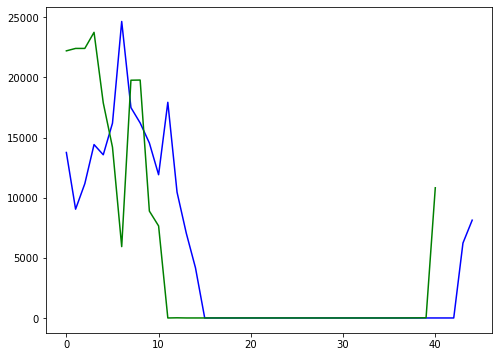

In [21]:
transform = True
mts = VARPipeline(country="samoa",
                  y_var=["total", "seats_arrivals_intl"],
                  exog_var=["covid", "stringency_index", "samoa_travel"],
                  training_ratio=0.95)
mts.read_and_merge()


raw = mts.data
df = raw[raw.date >= "2019-01-01"].reset_index(drop=True).dropna()
print(mts.test_stationarity(df, ["total", "seats_arrivals_intl"]))

scaler = ScaledLogitScaler()
scaler.fit(raw[["total", "seats_arrivals_intl"]])

if transform:
    train_data = scaler.transform(raw[["total", "seats_arrivals_intl"]]).dropna()
else:
    train_data = raw[["total", "seats_arrivals_intl"]].dropna()
index = train_data.index
exog_data = raw[["covid", "stringency_index", "samoa_travel"]].iloc[index]

selected_orders = select_order(train_data, exog=exog_data, maxlags=5)

# Extract values and count occurrences
order_counts = Counter(selected_orders.selected_orders.values())
selected_order = order_counts.most_common(1)[0][0]

johansen_test = coint_johansen(train_data,
                               det_order=0,
                               k_ar_diff=selected_order)

# Determine the number of cointegrating relationships
coint_rank = sum(
    johansen_test.lr1
    > johansen_test.cvt[:, 0])  # Number of relations with p-value < 0.05
print(selected_order, coint_rank)

mod = VECM(train_data,
           k_ar_diff=selected_order,
           coint_rank=coint_rank,
           exog=exog_data)
res = mod.fit()

covid = CovidDataLoader("palau").read_covid_data()
trend = TrendsDataLoader("palau").read_trends_data()
exog_df = covid.merge(trend[["date", "palau travel"]])
exog_df.columns = [col.replace(" ", "_") for col in exog_df.columns]
exog_df = exog_df.iloc[len(train_data) - 12:]

forecast = res.predict(steps=len(exog_df)-1, exog_fc=exog_df.iloc[:-1, [2, 1,3]])
if transform:
    forecast = scaler.inverse_transform(forecast)
    fitted_values = scaler.inverse_transform(res.fittedvalues)
else:
    fitted_values = res.fittedvalues
    
    
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(df['total'].values, color='blue')
plt.plot(fitted_values[:, 0], color="green")

In [17]:
from pmdarima.model_selection import SlidingWindowForecastCV, RollingForecastCV

from typing import List, Tuple
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM


def cross_validate(endog_data: pd.DataFrame, exog_data: pd.DataFrame,
                   maximum_order: int, criteria: str) -> List[List[float]]:
    """
    Perform cross-validation for Vector Error Correction Models (VECM) over a range of orders.

    This function uses a rolling forecast cross-validation approach to evaluate the performance
    of VECM models with different lag orders. It calculates the error for each model based on a specified
    evaluation criteria.

    Parameters:
    endog_data (pd.DataFrame): The endogenous variables of the VECM.
    exog_data (pd.DataFrame): The exogenous variables of the VECM.
    maximum_order (int): The maximum order of VECM to be tested.
    criteria (str): The criteria used to evaluate the model's performance (e.g., 'mse' for Mean Squared Error).

    Returns:
    List[List[float]]: A list containing the errors for each model order. Each sublist corresponds to a different order.
    """
    cv = RollingForecastCV(step=1, h=6, initial=20)
    cv_splits = list(cv.split(endog_data))

    model_errors = []
    for order in range(1, maximum_order + 1):
        order_errors = []
        for train_idx, test_idx in cv_splits:
            train_endog, train_exog = endog_data.iloc[
                train_idx], exog_data.iloc[train_idx]
            test_endog, test_exog = endog_data.iloc[test_idx], exog_data.iloc[
                test_idx]

            model = VECM(train_endog,
                         k_ar_diff=order,
                         coint_rank=1,
                         exog=train_exog)
            fitted_model = model.fit()

            forecast = fitted_model.predict(steps=len(test_endog),
                                            exog_fc=test_exog)
            error = calculate_evaluation(test_endog, forecast)
            order_errors.append(error[criteria])
        model_errors.append(order_errors)

    return model_errors

In [23]:
errors = cross_validate(train_data, exog_data, 5, "SMAPE")
for order, i in zip(range(1, len(errors)), errors):
    print(order, np.mean(i))

1 46.108441538258035
2 48.449941905765215
3 52.166695633792315
4 56.330575335086834
